# Model Evaluation

In [1]:
import torch
import os
import utils

import warnings
warnings.filterwarnings('ignore')

## Prepare Test Set

In [2]:
# path of img data
pth_train = 'Data/ISIC2017/Aug_Training_Data'
pth_valid = 'Data/ISIC2017/ISIC-2017_Validation_Data'
pth_test = 'Data/ISIC2017/ISIC-2017_Test_Data'


ann_train = utils.Annotation('Data/ISIC2017/ISIC-2017_Training_Aug_Part3_GroundTruth.csv')
ann_valid = utils.Annotation('Data/ISIC2017/ISIC-2017_Validation_Part3_GroundTruth.csv')
ann_test = utils.Annotation('Data/ISIC2017/ISIC-2017_Test_v2_Part3_GroundTruth.csv')

In [3]:
from torchvision import transforms
from torch.utils import data

transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])
                                ])

In [4]:
# create train dataset
train_data = utils.RandomPatch(ann_train.df, pth_train, transform=transform)
train_loader = data.DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)

# create validation dataset
valid_data = utils.RandomPatch(ann_valid.df, pth_valid, transform=transform)
valid_loader = data.DataLoader(valid_data, batch_size=32, shuffle=False)

# create test dataset
test_data = utils.RandomPatch(ann_test.df, pth_test, transform=transform)
test_loader = data.DataLoader(test_data, batch_size=32, shuffle=False)

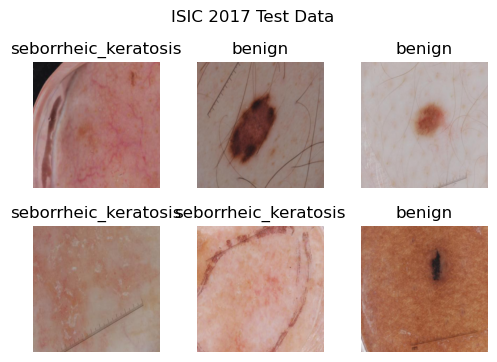

In [5]:
x, y = next(iter(test_loader))
labels = ann_test.to_names(y)

utils.show_samples(x, labels, 2, 3, "ISIC 2017 Test Data")

## Load Model

In [6]:
# GPU setting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
model = utils.load_model(device, name='arl50-6.pkl')

Load arl50-6.pkl on cuda successfully.


## Evaluation
In the test stage, we used the same patch extraction method to randomly crop nine patches from each test image, fed them to the trained network, and averaged the obtained scores as the predicted score of the image.

### Quantitative

In [8]:
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np
from sklearn import metrics


eval_metrics = utils.Evaluation(device, ann_test.categories)

def evaluation_report(model, data_loader):
    y, prob = eval_metrics.get_probs(model, data_loader)
    probs = [prob]
    for _ in range(8):
        _, prob = eval_metrics.get_probs(model, data_loader)
        probs.append(prob)
    prob = np.mean(probs, axis=0)
    eval_metrics.prob = prob
    
    eval_metrics.complete_scores()
    
    print(eval_metrics.report)
    fpr, tpr, roc_auc = eval_metrics.fpr, eval_metrics.tpr, eval_metrics.roc_auc
    
    for key in roc_auc.keys():
        print("AUC({}): {}".format(key, roc_auc[key]))
    
    # Plot ROC curves
    lw = 2
    plt.figure(dpi=100)
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(3), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend(loc="lower right")
    plt.show()

Test Set
                      precision    recall  f1-score   support

            melanoma       0.56      0.51      0.54       117
seborrheic_keratosis       0.71      0.44      0.55        90
              benign       0.79      0.88      0.83       393

            accuracy                           0.74       600
           macro avg       0.69      0.61      0.64       600
        weighted avg       0.74      0.74      0.73       600

AUC(0): 0.8275203057811753
AUC(1): 0.9149673202614379
AUC(2): 0.8432225787021672
AUC(micro): 0.9006097222222222
AUC(macro): 0.8631102780196686


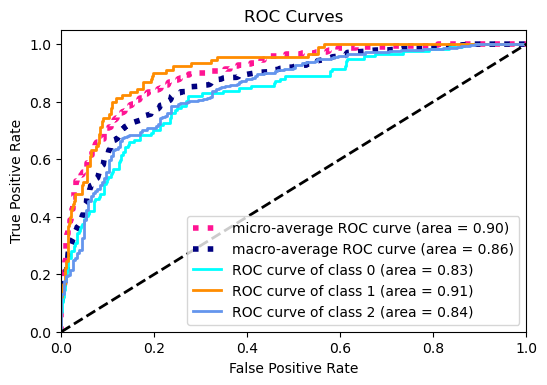

In [9]:
print("Test Set")
evaluation_report(model, test_loader)

Validation Set
                      precision    recall  f1-score   support

            melanoma       0.89      0.53      0.67        30
seborrheic_keratosis       0.90      0.83      0.86        42
              benign       0.80      0.95      0.87        78

            accuracy                           0.83       150
           macro avg       0.86      0.77      0.80       150
        weighted avg       0.84      0.83      0.83       150

AUC(0): 0.9138888888888889
AUC(1): 0.9874338624338624
AUC(2): 0.9544159544159544
AUC(micro): 0.9591777777777778
AUC(macro): 0.9556902048568715


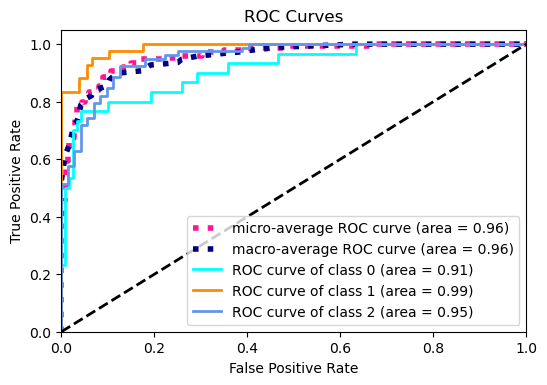

In [10]:
print("Validation Set")
evaluation_report(model, valid_loader)

# print("Training Set")
# evaluation_report(model, train_loader)

## Qualitative

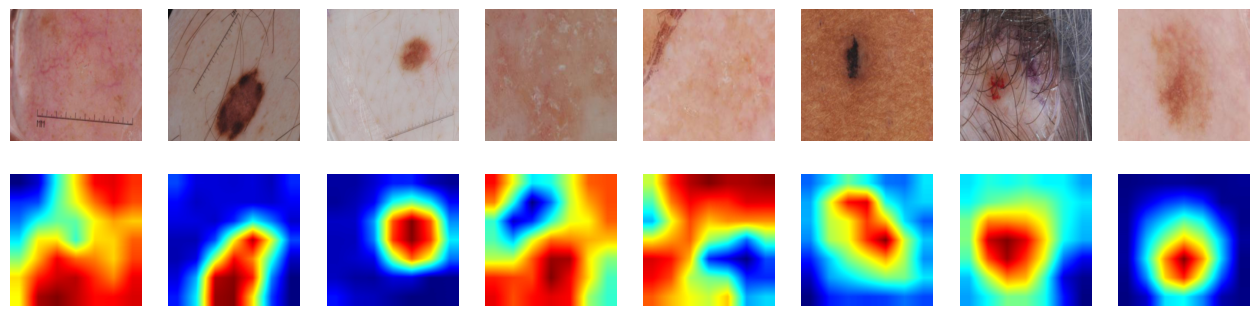

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

feature_map = None
def hook(model, inputs, outputs):
    global feature_map
    feature_map = outputs.cpu().detach()

model.layer4.register_forward_hook(hook)

weights = model.fc.weight.cpu().detach()

test_loader = data.DataLoader(test_data, batch_size=8, shuffle=False)

for x, y in test_loader:
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    fig, axes = plt.subplots(2, 8, facecolor='#ffffff', dpi=100, figsize=(16, 4))
    axes = [ax for ax in axes.flat]
    for i in range(8):
        img = x[i].detach().numpy().transpose((1, 2, 0))
        img = img * std + mean
        img = np.clip(img, 0, 1)
        axes[i].imshow(img)
        axes[i].axis("off")
    
    model.eval()
    x = x.to(device)
    class_idx = y.detach()
    z = model(x)
    
    cams = utils.CAM(feature_map, weights, class_idx)
    for i in range(8, 16):
        utils.draw_cam(axes[i], cams[i-8])
    plt.show()

    break